In [13]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

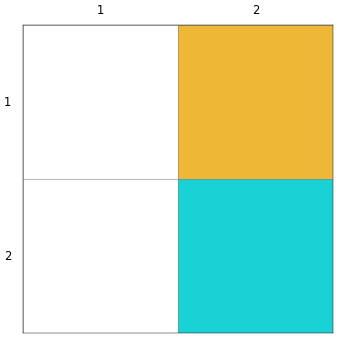

In [14]:
env = grid_env.GridEnv(size=2, target=[1, 1], forbidden=[[1, 0]],render_mode='')

首先我有一个Vk，当这个Vk还没有收敛的时候(收敛的情况就是Vk-Vk-1他还没有说小于一个很小的值)，我们就做下面的事：
假设这是第k次的iteration，首先我们遍历所有的状态s，然后对于所有的状态s，我们遍历它所有的action，计算出来每一个s对应的action的这个qk，这里 $$qk = \sum_r p(r \mid s, a) r + \gamma \sum_{s'} p(s' \mid s, a) v_k(s')$$
首先，我们要看到哪一个action对应的是最大的qk，然后policy update就是选择这个action。value update就是这个最大的qk.$$ Vk+1 = maxaQk(a,s) $$

In [15]:
def value_iteration(env, theta = 0.0001, gamma = 0.8, steps=100):
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size
    reward_list = env.reward_list
    reward_space_size = len(reward_list)
    
    # 初始化状态值函数
    state_value_k = np.zeros(shape=(state_space_size))  # 初始化状态值函数为全零的数组，形状为 (state_space_size)，记录每个状态的值。
    policy = np.zeros(shape=(state_space_size, action_space_size))  # 初始化策略
    
    for step in range(steps):
        delta = 0  # 用于记录状态值更新的最大变化
        
        # 遍历每一个状态
        for state in range(state_space_size):
            qvalue_list = []
            
            # 遍历每一个动作，计算每个动作的Q值
            for action in range(action_space_size):
                qvalue = 0
                
                # 累加奖励
                for i in range(reward_space_size):
                    qvalue += reward_list[i] * env.Rsa[state, action, i]
                
                # 累加未来状态值的折扣回报
                for next_state in range(state_space_size):
                    qvalue += gamma * env.Psa[state, action, next_state] * state_value_k[next_state]
                
                qvalue_list.append(qvalue)
            
            # 更新状态值函数
            best_qvalue = max(qvalue_list)
            delta = max(delta, np.abs(best_qvalue - state_value_k[state]))
            state_value_k[state] = best_qvalue
            
            # 选择最优动作并更新策略
            best_action = np.argmax(qvalue_list)
            policy[state] = np.eye(action_space_size)[best_action]
        
        # 检查是否满足收敛条件
        if delta < theta:
            print(f"Converged after {step + 1} steps.")
            break
    
    return policy, state_value_k

In [16]:
policy , a =value_iteration(env)

Converged after 43 steps.


e:\Reinforcement_learning\scripts\render.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


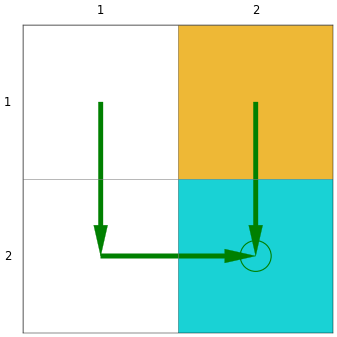

In [17]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[1, 1], forbidden=[[1, 0]], size=2)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()